# Notebook 1: Intuition for ML

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA

from utils import get_mnist_dataset

Firstly, we will load the MNIST dataset with the get_mnist_dataset, located in `utils.py` in our `transformers_workshop` folder. The dataset is pre-normalized by the mean and std in the training set.

In [4]:
train_dataset, test_dataset = get_mnist_dataset()

Mean: 0.13066047430038452, Std: 0.30810779333114624


torch.Size([1, 28, 28])
torch.Size([28, 28])


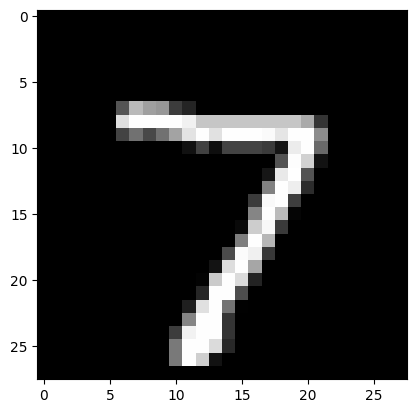

Label: 7


In [5]:
# Preview
print(test_dataset[0][0].shape)

# Shape (1, 28, 28) so we can squeeze away the 0th axis
img = test_dataset[0][0].squeeze(0)

print(img.shape)
# Now it is a 28x28 image
plt.imshow(img.numpy(), cmap='gray') # matplotlib expects numpy arrays
plt.show()

print(f'Label: {test_dataset[0][1]}')

torch.Size([784])


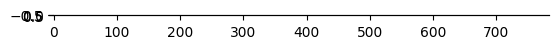

In [6]:
# When flattened, the image is a 784 length vector
print(img.flatten().shape)
plt.imshow(img.flatten().unsqueeze(0).numpy(), cmap='gray')
plt.show()
# Not very easy to see, but in principle the same image

Now, let's flatten the images into a 784 length vectors (28 x 28) and stack them into one big matrix. We will do for the data X and labels Y so that we can calculate parameters via the normal equations that provide the best linear unbiased solution. 

In [7]:
# Prepare data for normal equations (X^T X)^-1 X^T y
def prepare_data_for_normal_equations(dataset):
    """Convert dataset to matrices for normal equation solution"""
    X, y = [], []
    for image, label in tqdm(dataset, desc="Preparing data for normal equations"):
        flattened = image.flatten()
        X.append(flattened)
        # One-hot encode labels for multi-class regression
        one_hot = torch.zeros(10)
        one_hot[label] = 1
        y.append(one_hot)
    X = torch.stack(X)  # (n_samples, 784) - 784 features
    y = torch.stack(y)  # (n_samples, 10) - one-hot encoded labels
    return X, y

# Solve using normal equations: theta = (X^T X)^-1 X^T y
X_train, y_train = prepare_data_for_normal_equations(train_dataset)
X_test, y_test = prepare_data_for_normal_equations(test_dataset)
print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")

Preparing data for normal equations:   0%|          | 0/60000 [00:00<?, ?it/s]

Preparing data for normal equations:   0%|          | 0/10000 [00:00<?, ?it/s]

Training data shape: X=torch.Size([60000, 784]), y=torch.Size([60000, 10])
Test data shape: X=torch.Size([10000, 784]), y=torch.Size([10000, 10])


In [8]:
# Compute normal equations solution (use pseudo-inverse for stability)
X_T = X_train.t()  # Transpose
XTX = torch.matmul(X_T, X_train)  # X^T X
XTX_pinv = torch.linalg.pinv(XTX)  # (X^T X)^+ (pseudo-inverse)
XTy = torch.matmul(X_T, y_train)  # X^T y
theta = torch.matmul(XTX_pinv, XTy)  # Final solution
print(f"Learned parameters shape: {theta.shape}")  # Should be (784, 10)

# Test accuracy
y_pred = torch.matmul(X_test, theta)  # Apply linear model: y = X * theta
pred_labels = torch.argmax(y_pred, dim=1)  # Get predicted class labels
true_labels = torch.argmax(y_test, dim=1)  # Get true class labels
accuracy = (pred_labels == true_labels).float().mean()
print(f"Linear regression test accuracy: {accuracy:.4f}")

Learned parameters shape: torch.Size([784, 10])
Linear regression test accuracy: 0.8596


The matrix `theta` has shape (784, 10), where each column contains pixel weights for one class. We can reshape each column to 28×28 and plot it as a heatmap, one with and without contours. Positive weights (red) increase the class logit; negative weights (blue) decrease it. Contour lines help highlight "strokes" or edges learned by the linear model.

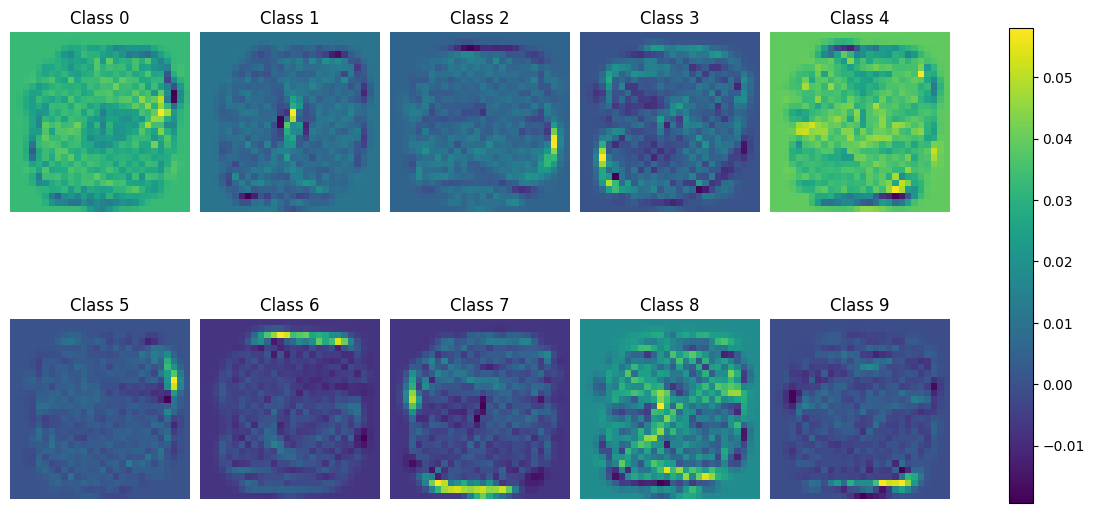

In [9]:
W = theta.detach().cpu().numpy()
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.ravel()
for i in range(10):
    im = axes[i].imshow(W[:, i].reshape(28, 28))
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.colorbar(im, ax=axes.tolist(), shrink=0.85)
plt.show()

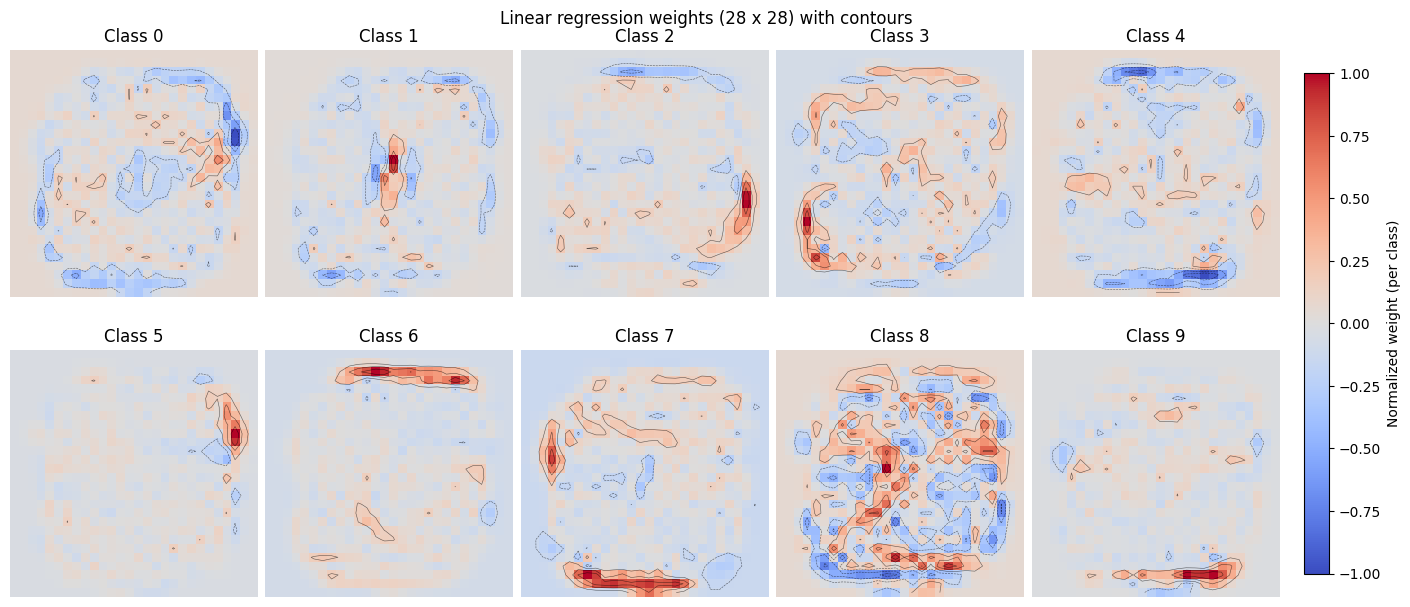

In [10]:
# theta from the normal equation section: shape (784, 10)
W = theta.detach().cpu().numpy()

# Normalize per-class for clearer visualization (scale invariant per map)
W_norm = W / (np.maximum(np.abs(W).max(axis=0, keepdims=True), 1e-8))

fig, axes = plt.subplots(2, 5, figsize=(14, 6), constrained_layout=True)
axes = axes.ravel()

# Common color scaling across classes for comparability
vmin, vmax = -1.0, 1.0
cmap = 'coolwarm'

for cls in range(10):
    ax = axes[cls]
    img = W_norm[:, cls].reshape(28, 28)
    im = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    # Add a few contour lines to emphasize "strokes"
    ax.contour(img, levels=np.linspace(-0.7, 0.7, 6), colors='k', linewidths=0.4, alpha=0.6)
    ax.set_title(f"Class {cls}")
    ax.axis('off')

# Single shared colorbar
cbar = fig.colorbar(im, ax=axes.tolist(), shrink=0.85, pad=0.02)
cbar.set_label('Normalized weight (per class)')
plt.suptitle('Linear regression weights (28 x 28) with contours', y=1.02)
plt.show()


Another way to think about solving MNIST is building a representative vector for each class, and then using a vector similarity heuristic to decide which class average the input is closest too.

In [11]:
class AveragingClassifier(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super().__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        # Store class averages as parameters
        self.class_averages = nn.Parameter(torch.zeros(num_classes, input_size))
        
    def fit(self, dataset):
        """Compute the average image for each class"""
        # Initialize accumulators
        class_sums = torch.zeros(self.num_classes, self.input_size)
        class_counts = torch.zeros(self.num_classes)
        
        # Accumulate images by class
        for image, label in tqdm(dataset, desc="Flattening images"):
            flattened = image.flatten()  # Flatten 28x28 to 784
            class_sums[label] += flattened
            class_counts[label] += 1
            
        # Compute averages
        for i in tqdm(range(self.num_classes), desc="Computing class averages"):
            self.class_averages.data[i] = class_sums[i] / class_counts[i]
    
    def forward(self, x, sim_type: str = 'cosine'):
        # Flatten input images
        x_flat = x.view(x.size(0), -1)  # (batch_size, 784)
        # Compute dot product with each class average
        # x_flat: (batch_size, 784), class_averages: (10, 784)
        if sim_type == 'cosine':
            # Normalize vectors
            x_flat = F.normalize(x_flat, p=2, dim=1)
            class_averages = F.normalize(self.class_averages, p=2, dim=1)
            logits = torch.mm(x_flat, class_averages.t())  # (batch_size, 10)
        elif sim_type == 'euc':
            logits = -torch.cdist(x_flat, self.class_averages)  # (batch_size, 10)
        elif sim_type == 'dot':
            logits = torch.mm(x_flat, self.class_averages.t())  # (batch_size, 10)
        else:
            raise ValueError(f"Invalid similarity type: {sim_type}")
        return logits

In [12]:
# Create and train the averaging classifier
model = AveragingClassifier()
print("Fitting averaging classifier...")
model.fit(train_dataset)
print("Done!")

Fitting averaging classifier...


Flattening images:   0%|          | 0/60000 [00:00<?, ?it/s]

Computing class averages:   0%|          | 0/10 [00:00<?, ?it/s]

Done!


`model.class_averages` stores one 784-length vector per class. We can reshape each to 28×28 and display them as heatmaps with contour lines to highlight the characteristic "strokes" captured by simple averaging.


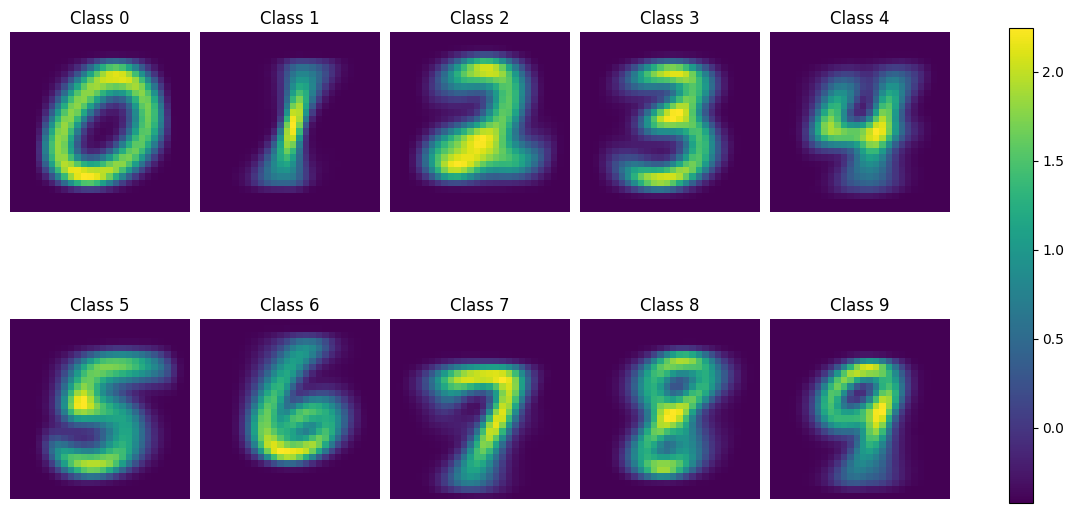

In [13]:
A = model.class_averages.detach().cpu().numpy()
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.ravel()
for i in range(10):
    im = axes[i].imshow(A[i].reshape(28, 28))
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.colorbar(im, ax=axes.tolist(), shrink=0.85)
plt.show()

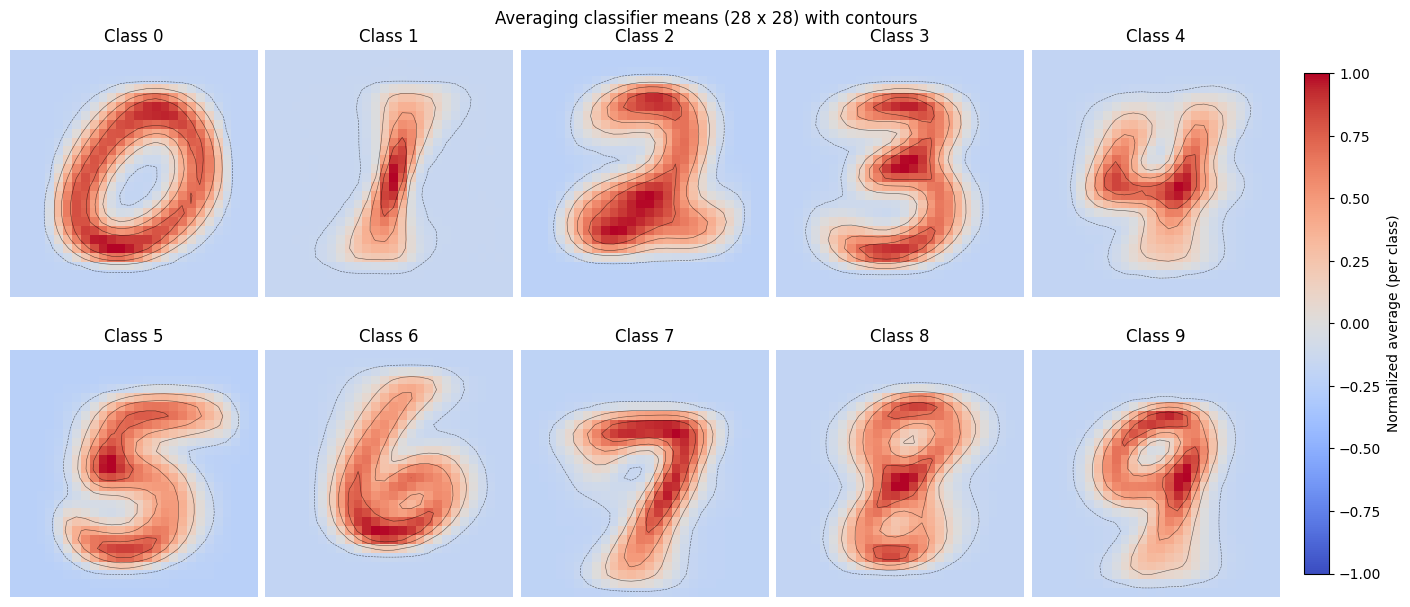

In [14]:
# class_averages: (10, 784)
A = model.class_averages.detach().cpu().numpy()

# Normalize per-class for clearer visualization (scale invariant per map)
A_norm = A / (np.maximum(np.abs(A).max(axis=1, keepdims=True), 1e-8))

fig, axes = plt.subplots(2, 5, figsize=(14, 6), constrained_layout=True)
axes = axes.ravel()

# Common color scaling across classes for comparability
vmin, vmax = -1.0, 1.0
cmap = 'coolwarm'

for cls in range(10):
    ax = axes[cls]
    img = A_norm[cls].reshape(28, 28)
    im = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    # Add a few contour lines to emphasize "strokes"
    try:
        ax.contour(img, levels=np.linspace(-0.7, 0.7, 6), colors='k', linewidths=0.4, alpha=0.6)
    except Exception:
        pass
    ax.set_title(f"Class {cls}")
    ax.axis('off')

# Single shared colorbar
cbar = fig.colorbar(im, ax=axes.tolist(), shrink=0.85, pad=0.02)
cbar.set_label('Normalized average (per class)')
plt.suptitle('Averaging classifier means (28 x 28) with contours', y=1.02)
plt.show()


Let's see how well it does on the test set. I hypothesize that cosine similarity or euclidean distance will perform better than dot product.

In [15]:
# See test accuracy
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

total, correct = 0, 0
for sim_type in ['cosine', 'euc', 'dot']:
    for images, labels in tqdm(test_loader, desc=f"Testing {sim_type}"):
        outputs = model(images, sim_type=sim_type)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    print(f"Test accuracy for {sim_type}: {100 * correct / total}%")

Testing cosine:   0%|          | 0/20 [00:00<?, ?it/s]

Test accuracy for cosine: 82.4%


Testing euc:   0%|          | 0/20 [00:00<?, ?it/s]

Test accuracy for euc: 82.215%


Testing dot:   0%|          | 0/20 [00:00<?, ?it/s]

Test accuracy for dot: 79.5%


Indeed, cosine similarity is the best. It is sort of the most "normalized" similarity heuristic, and that simplicity often works well when simple comparisons are required like this.

Now, let's analyze the parameter solutions from linear regression vs. our averaging experiment.

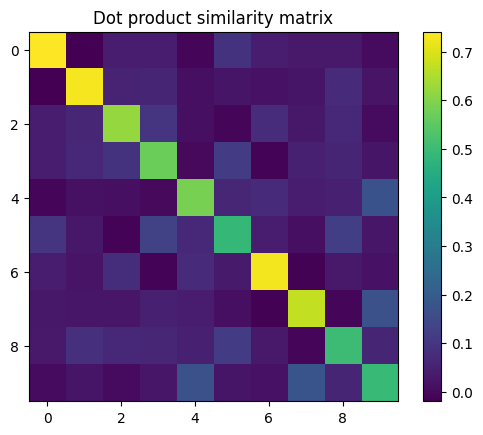

In [16]:
a = theta # (784, 10), this is from linear regression
b = model.class_averages # (10, 784), this is from averaging

c = b @ a # (10, 10), this matmul is a dot product similarity matrix between the class averages and the learned parameters
plt.imshow(c.detach().numpy())
plt.title("Dot product similarity matrix")
plt.colorbar()
plt.show()

This type of analysis is actually very similar to attention!

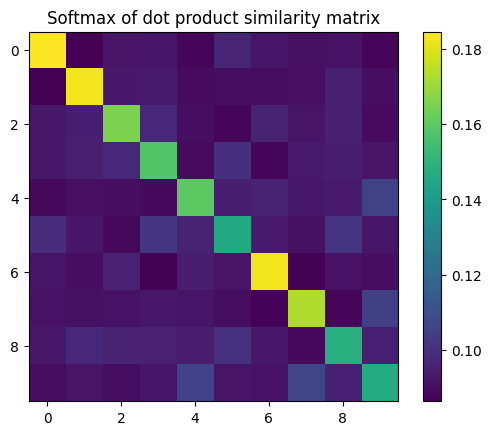

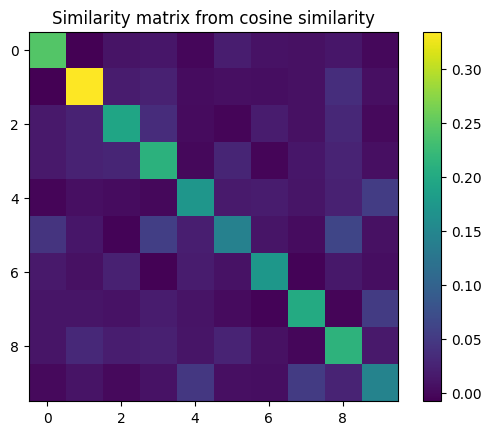

In [17]:
# We can normalize first or use softmax to get a better compairson

c = c.softmax(dim=-1)
plt.imshow(c.detach().numpy())
plt.title("Softmax of dot product similarity matrix")
plt.colorbar()
plt.show()

a = F.normalize(theta, p=2, dim=0)
b = F.normalize(model.class_averages, p=2, dim=1)
c = b @ a
plt.imshow(c.detach().numpy())
plt.title("Similarity matrix from cosine similarity")
plt.colorbar()
plt.show()

Interestingly, the two methods find a somewhat similar answer!

I like to think of the last layer of a neural network as doing this averaging experiment. The layers before that sort of handle the feature engineering and the last layer tries to store historical records of the examples for each class (at that stage) and figure out which one is closest. In reality, it not quite such a clean distinction, but I think it helps with interpreting the "black box."

### Simple MLP classifier + PCA decision boundaries

We train a small MLP on flattened MNIST and compare accuracy to the linear regression and averaging approaches. Then we fit a 2D PCA on the flattened inputs and plot the MLP’s decision regions by projecting a 2D grid through PCA’s inverse transform back to pixel space.


In [18]:
# MLP model, training and evaluation
# Prepare loaders (reuse train/test_dataset from above)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


class MLP(nn.Module):
    def __init__(self, input_dim=784, hidden=1024, num_classes=10, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            nn.LayerNorm(hidden),
            nn.Linear(hidden, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            nn.Linear(hidden, num_classes),
        )
    def forward(self, x):
        return self.net(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_mlp = MLP().to(device)
print(summary(model_mlp, input_size=(1, 28, 28)))
opt = torch.optim.Adam(model_mlp.parameters(), lr=1e-3)


# Quick training loop (few epochs for speed)
def train_epoch(model, loader):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in tqdm(loader, desc="Training"):
        opt.zero_grad()
        logits = model(x.to(device))
        loss = F.cross_entropy(logits, y.to(device))
        loss.backward()
        opt.step()
        loss_sum += loss.item() * y.size(0)
        pred = logits.argmax(1).cpu()
        total += y.size(0)
        correct += (pred == y).sum().item()
    return loss_sum / total, correct / total


@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in tqdm(loader, desc="Evaluating"):
        logits = model(x.to(device))
        loss = F.cross_entropy(logits, y.to(device))
        loss_sum += loss.item() * y.size(0)
        pred = logits.argmax(1).cpu()
        total += y.size(0)
        correct += (pred == y).sum().item()
    return loss_sum / total, correct / total

EPOCHS = 5
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_epoch(model_mlp, train_loader)
    te_loss, te_acc = eval_epoch(model_mlp, test_loader)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | test loss {te_loss:.4f} acc {te_acc:.4f}")

mlp_test_acc = eval_epoch(model_mlp, test_loader)[1]
print(f"MLP test accuracy: {mlp_test_acc:.4f}")


Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─LayerNorm: 2-2                    [1, 784]                  1,568
│    └─Linear: 2-3                       [1, 1024]                 803,840
│    └─ReLU: 2-4                         [1, 1024]                 --
│    └─Dropout: 2-5                      [1, 1024]                 --
│    └─LayerNorm: 2-6                    [1, 1024]                 2,048
│    └─Linear: 2-7                       [1, 1024]                 1,049,600
│    └─ReLU: 2-8                         [1, 1024]                 --
│    └─Dropout: 2-9                      [1, 1024]                 --
│    └─Linear: 2-10                      [1, 10]                   10,250
Total params: 1,867,306
Trainable params: 1,867,306
Non-trainab

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 01 | train loss 0.2087 acc 0.9349 | test loss 0.1338 acc 0.9593


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 02 | train loss 0.0869 acc 0.9733 | test loss 0.0697 acc 0.9785


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 03 | train loss 0.0581 acc 0.9813 | test loss 0.0638 acc 0.9810


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 04 | train loss 0.0427 acc 0.9861 | test loss 0.0724 acc 0.9787


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 05 | train loss 0.0383 acc 0.9872 | test loss 0.0821 acc 0.9791


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

MLP test accuracy: 0.9791


Predicting grid:   0%|          | 0/79 [00:00<?, ?it/s]

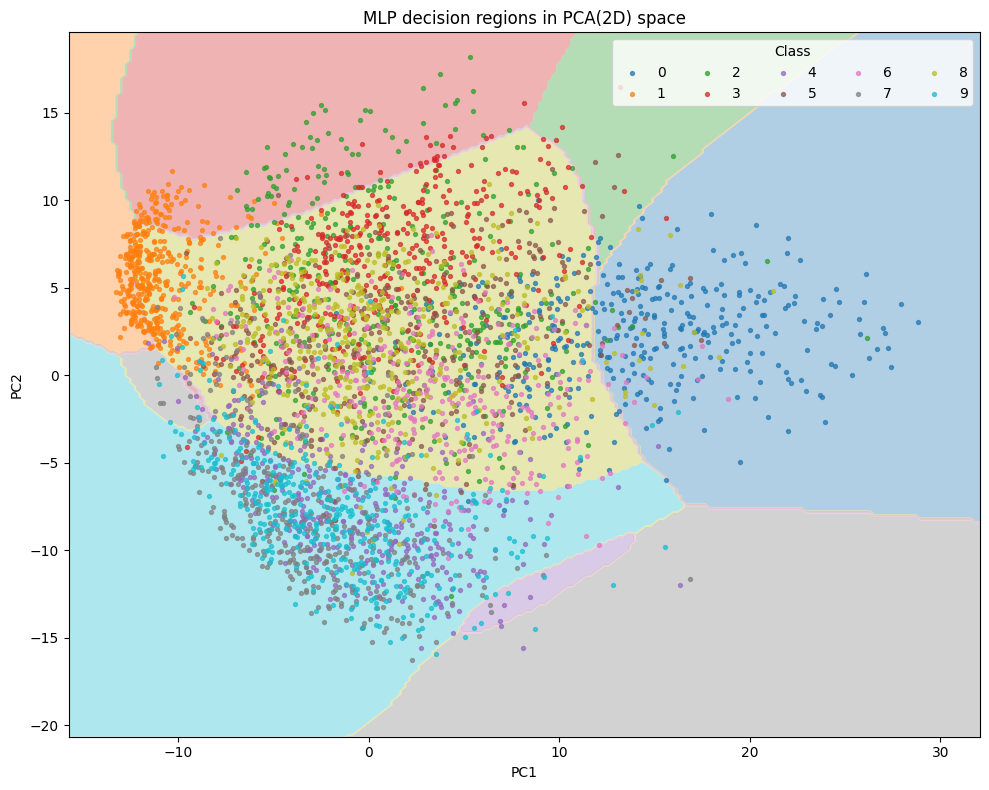

In [19]:
# PCA to 2D + MLP decision boundaries
# Build flattened arrays for PCA (train only for fit)
X_train_np = torch.stack([img.flatten() for img, _ in train_dataset]).numpy()
y_train_np = torch.tensor([label for _, label in train_dataset]).numpy()
X_test_np = torch.stack([img.flatten() for img, _ in test_dataset]).numpy()
y_test_np = torch.tensor([label for _, label in test_dataset]).numpy()

pca = PCA(n_components=2, random_state=0)
Z_train = pca.fit_transform(X_train_np)
Z_test = pca.transform(X_test_np)

# Decision grid in PCA space
x_min, x_max = Z_train[:,0].min()-2.0, Z_train[:,0].max()+2.0
y_min, y_max = Z_train[:,1].min()-2.0, Z_train[:,1].max()+2.0
grid_res = 200
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, grid_res),
    np.linspace(y_min, y_max, grid_res)
)
ZZ = np.c_[xx.ravel(), yy.ravel()]

pred_grid = np.empty(ZZ.shape[0], dtype=np.int64)
batch = 512
with torch.no_grad():
    for i in tqdm(range(0, ZZ.shape[0], batch), desc="Predicting grid"):
        X_grid = pca.inverse_transform(ZZ[i:i+batch])
        X_grid_t = torch.from_numpy(X_grid).float().view(-1, 1, 28, 28)
        logits = model_mlp(X_grid_t.to(device))
        pred_grid[i:i+batch] = logits.argmax(1).cpu().numpy()

# Plot boundaries with test points
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, pred_grid.reshape(xx.shape), levels=np.arange(11)-0.5, cmap='tab10', alpha=0.35, antialiased=True)
# Overlay a subsample of test points for clarity
idx = np.random.RandomState(0).choice(len(Z_test), size=min(4000, len(Z_test)), replace=False)
for k in range(10):
    ii = idx[y_test_np[idx] == k]
    plt.scatter(Z_test[ii,0], Z_test[ii,1], s=8, label=str(k), alpha=0.7)
plt.legend(title='Class', ncol=5, loc='upper right')
plt.title('MLP decision regions in PCA(2D) space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()
